In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import timeit
import h5py
from pathlib import Path
import numpy as np
from itertools import product
import pickle
import scipy.special
import scipy.stats
from math import exp
import multiprocessing
import functools

from montecarlo import DataLogger

%matplotlib inline
np.seterr(all='warn')
textwidth = 6.268
mpl.rcParams['figure.dpi'] = 70
default_figargs = dict(figsize = (textwidth,textwidth))

from montecarlo import *

In [ ]:
%%time
from direct_partition_functions import direct
from montecarlo import *
from time import time

N_steps = int(0.1 * 1000)
N_burn_in = int(0.1 * 1000)

MCMC_params = dict(
        N_steps = N_steps, N_burn_in = N_burn_in, 
        state=None, 
        logger = NfNc(),
        proposal = p_multi_site_uniform_reflect,
        proposal_args = dict(lam = 4),
        accept_function = simple_accept,
    )

Us = [0,1,10]
Js = [0,1,10]
mu = np.linspace(-5,5,10)
Ns = [2,5,10,15,30,50]
rho_vs_mu_params = dict(t = 1, alpha = 1.5, beta = 1/2, normalise = True)

def compute(mu, **kwargs):
    kwargs['parameters']['mu'] = mu
    return FK_mcmc_2(**kwargs)


data = np.zeros(shape = (len(Js), len(Us), len(Ns), 4, len(mu)))

with multiprocessing.Pool(multiprocessing.cpu_count() - 2) as pool:
    for Jslice, J in zip(data, Js):
        for Uslice, U in zip(Jslice, Us):
            for Nslice, N in zip(Uslice, Ns):
                t0 = time()
                these_params = rho_vs_mu_params.copy()
                these_params.update(J=J, U=U)
                MCMC_params.update(state = np.arange(N) % 2)

                curried = functools.partial(compute, parameters = these_params, **MCMC_params)
                mc_Nf, mc_Nc, mc_dNf, mc_dNc = np.array(pool.map(curried, mu)).T

                np.copyto(Nslice, np.array([mc_Nf, mc_Nc, mc_dNf, mc_dNc]))
                print(f'J={J}, N = {N}, time = {time() - t0:.0f} seconds')

np.savez('./pickled_data/density_vs_mu.npz', 
        Us=Us, Js=Js, mu=mu, Ns=Ns, rho_vs_mu_params=rho_vs_mu_params, MCMC_params=MCMC_params,
        data=data, allow_pickle = True,
        )
print('done')

Warning, p_acc = 0.8675, {'t': 1, 'alpha': 1.5, 'beta': 0.5, 'normalise': True, 'J': 0, 'U': 0, 'mu': -0.5555555555555554, 'J_matrix': 'suppressed for brevity'}
Warning, p_acc = 0.565, {'t': 1, 'alpha': 1.5, 'beta': 0.5, 'normalise': True, 'J': 0, 'U': 0, 'mu': -1.6666666666666665, 'J_matrix': 'suppressed for brevity'}
Warning, p_acc = 0.86, {'t': 1, 'alpha': 1.5, 'beta': 0.5, 'normalise': True, 'J': 0, 'U': 0, 'mu': 0.5555555555555554, 'J_matrix': 'suppressed for brevity'}
Warning, p_acc = 0.14, {'t': 1, 'alpha': 1.5, 'beta': 0.5, 'normalise': True, 'J': 0, 'U': 0, 'mu': -5.0, 'J_matrix': 'suppressed for brevity'}
Warning, p_acc = 0.5725, {'t': 1, 'alpha': 1.5, 'beta': 0.5, 'normalise': True, 'J': 0, 'U': 0, 'mu': 1.666666666666667, 'J_matrix': 'suppressed for brevity'}
Warning, p_acc = 0.19, {'t': 1, 'alpha': 1.5, 'beta': 0.5, 'normalise': True, 'J': 0, 'U': 0, 'mu': 3.8888888888888893, 'J_matrix': 'suppressed for brevity'}
Warning, p_acc = 0.1, {'t': 1, 'alpha': 1.5, 'beta': 0.5, 'n

In [66]:
%%time
from direct_partition_functions import direct
from montecarlo import NfNc
from time import time

direct_Ns = [2,5,10,15]
direct_data = np.zeros(shape = (len(Js), len(Ns), 2, len(mu)))

with multiprocessing.Pool(multiprocessing.cpu_count() - 1) as pool:
    for Jslice, J in zip(direct_data, Js):
        for Nslice, N in zip(Jslice, direct_Ns):
            t0 = time()
            Ff, Fc, Nf, Nc, *Mf_moments = np.array([direct(system_size=N, mu=m, J=J, **rho_vs_mu_params) for m in mu]).T
            np.copyto(Nslice, np.array([Nf, Nc]))
            print(f'N = {N}, time = {time() - t:.0f} seconds')

np.savez('./pickled_data/direct_density_vs_mu.npz', 
         Js=Js, mu=mu, direct_Ns = direct_Ns, direct_data=direct_data, rho_vs_mu_params=rho_vs_mu_params, allow_pickle = True,
        )
print('done')

done
CPU times: user 1min 54s, sys: 7.24 s, total: 2min 2s
Wall time: 1min 54s


In [60]:
rho_vs_mu_params

array({'t': 1, 'alpha': 1.5, 'beta': 0.5, 'U': 10, 'normalise': True},
      dtype=object)

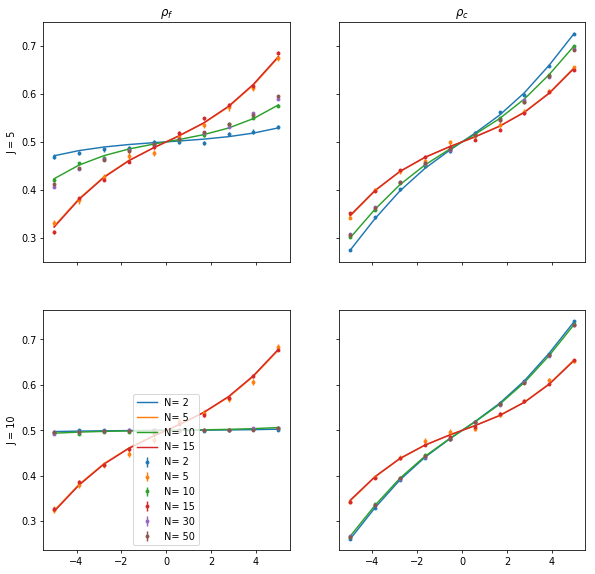

In [71]:
#%%time
pickled_data = np.load('./pickled_data/density_vs_mu.npz', allow_pickle = True)
locals().update(pickled_data)
pickled_data = np.load('./pickled_data/direct_density_vs_mu.npz', allow_pickle = True)
locals().update(pickled_data)
rho_vs_mu_params = rho_vs_mu_params[()]

f, axes = plt.subplots(len(Js),2,figsize = (2*5,len(Js)*5), sharex = 'col', sharey = 'row', squeeze = False)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for (axf, axc), d_Jslice, Jslice, J in zip(axes, direct_data, data, Js):
    for col, d_Nslice, N in zip(colors, d_Jslice, direct_Ns):
        Nf, Nc = d_Nslice
        axf.plot(mu, Nf, label = f'N= {N}', color=col)
        axc.plot(mu, Nc, label = f'N = {N}', color=col)
        
    for col, Nslice, N in zip(colors, Jslice, Ns):
        mc_Nf, mc_Nc, mc_dNf, mc_dNc = Nslice
        axf.errorbar(mu, mc_Nf, yerr = mc_dNf, fmt = '.', color=col, label = f'N= {N}')
        axc.errorbar(mu, mc_Nc, yerr = mc_dNc, fmt = '.', color=col)
        
axf.legend()
        
axes[0,0].set(title = r'$\rho_f$') 
axes[0,1].set(title = r'$\rho_c$') 
for ax,J in zip(axes.T[0], Js): ax.set(ylabel = f'J = {J}') 